# Word2Vec from Scratch (Optional)

This week we learnt about different word embedding techniques and how they help represent text in a more meaningful way as compared to traditional feature engineering techniques like TF-IDF etc.

In this notebook, we will:
+ Build a CBOW Word2Vec model from scratch
+ Build a Skipgram Word2Vec model from scratch

We will leverage a sample dataset to train our models and use ``tensforflow`` to build the models.

In [1]:
!nvidia-smi

Mon Jul 19 22:22:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.options.display.max_colwidth = 200
%matplotlib inline

In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Utility to Normalize Text Corpus

In [4]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

## Load a Sample Dataset

In [7]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 


In [17]:
# print(type(bible))
# y = [x for x in bible]
# print(y[30_090:30_103])


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[['22', ':', '15', 'For', 'without', 'are', 'dogs', ',', 'and', 'sorcerers', ',', 'and', 'whoremongers', ',', 'and', 'murderers', ',', 'and', 'idolaters', ',', 'and', 'whosoever', 'loveth', 'and', 'maketh', 'a', 'lie', '.'], ['22', ':', '16', 'I', 'Jesus', 'have', 'sent', 'mine', 'angel', 'to', 'testify', 'unto', 'you', 'these', 'things', 'in', 'the', 'churches', '.'], ['I', 'am', 'the', 'root', 'and', 'the', 'offspring', 'of', 'David', ',', 'and', 'the', 'bright', 'and', 'morning', 'star', '.'], ['22', ':', '17', 'And', 'the', 'Spirit', 'and', 'the', 'bride', 'say', ',', 'Come', '.'], ['And', 'let', 'him', 'that', 'heareth', 'say', ',', 'Come', '.'], ['And', 'let', 'him', 'that', 'is', 'athirst', 'come', '.'], ['And', 'whosoever', 'will', ',', 'let', 'him', 'take', 'the', 'water', 'of', 'life', 'freely', '.'], ['22', ':', '18', 'For', 'I', 'testify', 'unto', 'every', 'man', 'that', 'heareth', 'the', 'words', 'of', 'the', 'prophe

In [18]:

remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## The Word2Vec Model
This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

+ The Continuous Bag of Words (CBOW) Model
+ The Skip-gram Model

## Build Word2Vec : CBOW

### The Continuous Bag of Words (CBOW) Model
The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

Considering a simple sentence, __“the quick brown fox jumps over the lazy dog”__, this can be pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy)__ and so on.

Thus the model tries to predict the target_word based on the context_window words.

<img src="https://i.imgur.com/ATyNx6u.png">

In [19]:
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence

### Build Corpus Vocabulary

To start off, we will first build our corpus vocabulary where we extract out each unique word from our vocabulary and map a unique numeric identifier to it.


In [21]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


Thus you can see that we have created a vocabulary of unique words in our corpus and also ways to map a word to its unique identifier and vice versa. The `PAD` term is typically used to pad context words to a fixed length if needed.

### Build a CBOW (context, target) generator

We need pairs which consist of a target centre word and surround context words. In our implementation, a ___target word___ is of length __1__ and surrounding context is of length __`2 x window_size`__ where we take __`window_size`__ words before and after the target word in our corpus. This will become clearer with the following example.

In [27]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield (x, y)

In [ ]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 100:
            break
        i += 1

### Build the CBOW Architecture

In [32]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: tf.math.reduce_mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


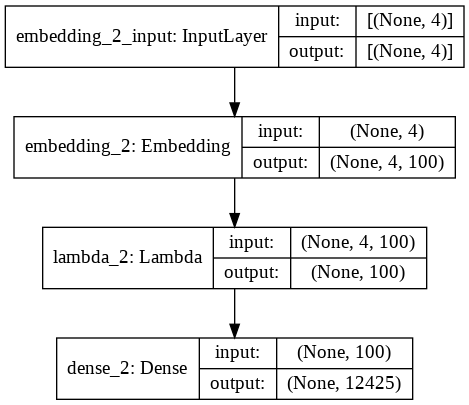

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(cbow, show_shapes=True, show_layer_names=True, 
                 rankdir='TB')

### Train the Model

This usually takes a pretty long time (couple of hours!)

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4270118.2470734585

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 5558616.089859169

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 5720339.524815647

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs


### Get Word Embeddings

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

### Find Similar Words

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

## Build Word2Vec: Skipgram

### The Skip-gram Model
The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word).

Considering our simple sentence from earlier, __“the quick brown fox jumps over the lazy dog”__. If we used the CBOW model, we get pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like __([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy)__ and so on.

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context __[quick, fox]__ given target word __‘brown’__ or __[the, brown]__ given target word __‘quick’__ and so on.

Thus the model tries to predict the context_window words based on the target_word.

<img src="https://i.imgur.com/95f3eVF.png">

Further details can be found in [Text Analytics with Python](https://github.com/dipanjanS/text-analytics-with-python/tree/master/New-Second-Edition/Ch04%20-%20Feature%20Engineering%20for%20Text%20Representation)

### Build the corpus vocabulary

To start off, we will follow the standard process of building our corpus vocabulary where we extract out each unique word from our vocabulary and assign a unique identifier, similar to what we did in the CBOW model. We also maintain mappings to transform words to their unique identifiers and vice-versa.


In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

### Build a skip-gram [(target, context), relevancy] generator

It’s now time to build out our skip-gram generator which will give us pair of words and their relevance like we discussed earlier. Luckily, keras has a nifty `skipgrams` utility which can be used and we don’t have to manually implement this generator like we did in CBOW.

Note: The function `skipgrams(…)` is present in `tf.keras.preprocessing.sequence`

This function transforms a sequence of word indexes (list of integers) into tuples of words of the form:
- (word, word in the same window), with label 1 (positive samples).
- (word, random word from the vocabulary), with label 0 (negative samples).


In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

### Build the Skipgram Architecture

In [ ]:
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [ ]:
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_arch)
model = Model([word_model.input,context_model.input], model_arch)
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB')

### Train the Model

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

### Get Word Embeddings

In [ ]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

### Find Similar Words

In [ ]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

### Visualize Word Embeddings

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

__NOTE__: Both models seem to have achieved decent results with the skipgram showing better results in terms of context, but leave a good scope for improvement. We encourage you to train both models for additional epochs and compare against ``gensim`` models.